In [1]:
import nltk
import pandas as pd
import numpy as np
import re
from nltk.corpus import wordnet
from nltk.stem import WordNetLemmatizer
from nltk.stem import PorterStemmer
from nltk.tokenize import RegexpTokenizer
import string
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
import curses.ascii
from nltk.tokenize import word_tokenize
from  sklearn.decomposition import NMF
from collections import defaultdict
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
nltk.download('wordnet')
nltk.download('maxent_treebank_pos_tagger')
nltk.download('averaged_perceptron_tagger')

[nltk_data] Downloading package wordnet to /home/ubuntu/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package maxent_treebank_pos_tagger to
[nltk_data]     /home/ubuntu/nltk_data...
[nltk_data]   Package maxent_treebank_pos_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /home/ubuntu/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


True

In [2]:
nytimes = pd.read_csv('nytimes_text_1985_2018.csv', encoding='ISO-8859-1')

In [3]:
# remove articls in spanish
nytimes = nytimes[nytimes.url.str.contains('/es/')==False]

In [4]:
def strip_accentes(input_string):
    clean_string = "".join([letter for letter in input_string if curses.ascii.isascii(letter)])
    return(clean_string)

In [5]:
# remove accents from article text
nytimes['article_text'] = [strip_accentes(article) for article in nytimes['article_text']]

In [6]:
# crate a function that takes a string and lemmatizes it 
def lemmatizer(text):
    tokens = word_tokenize(text)
    tagged = nltk.pos_tag(tokens)
    lemmatizer = WordNetLemmatizer()
    lem_words = []
    for tagged_word in tagged:
        word = tagged_word[0].lower()
        if tagged_word[1].startswith('VB'):
            word_tag = 'v'
        elif tagged_word[1].startswith('JJ'):
            word_tag = 'a'
        elif tagged_word[1].startswith('RB'):
            word_tag = 'r'
        else:
            word_tag = 'n'
                 
        lem_words.append(lemmatizer.lemmatize(word,pos=word_tag))
    return(lem_words)

In [7]:
# lemmatize words in articles
nytimes['lem_tokens'] = [lemmatizer(article) for article in nytimes['article_text']]

In [8]:
# turn lemmatized and stemmed tokens back into sting form
nytimes['lem_text'] = [" ".join(lems) for lems in nytimes['lem_tokens']]

In [9]:
nytimes['date'] = pd.to_datetime(nytimes['date'])
nytimes['year'] = nytimes['date'].dt.year

In [10]:
nytimes.head()

,date,headline,id,score,snippet,source,type,url,word_count,article_text,lem_tokens,lem_text,year
0,1985-02-19,"b'KOCH, IN WAHINGTON, HAS PRAISE FOR CUOMO'",4fd141f48eb7c8105d61a513,0.037857,"b""Once a political rival, sometimes a politica...",The New York Times,News,https://www.nytimes.com/1985/02/19/nyregion/ko...,609,"Once a political rival, sometimes a political...","[once, a, political, rival, ,, sometimes, a, p...","once a political rival , sometimes a political...",1985
1,1985-03-06,b'Senate Seeks to Ease Restrictions on Guns',4fd14eb08eb7c8105d62ed73,0.057113,b'The State Senate passed a bill today that wo...,The New York Times,News,https://www.nytimes.com/1985/03/06/nyregion/se...,161,The State Senate passed a bill today that wou...,"[the, state, senate, pass, a, bill, today, tha...",the state senate pass a bill today that would ...,1985
2,1985-04-09,"b""We're Killing One Another at a Great Rate""",4fd15c448eb7c8105d64316d,0.086703,b'To the Editor: According to a recent rep...,The New York Times,Letter,https://www.nytimes.com/1985/04/09/opinion/l-w...,313,To the Editor: According to a recent report b...,"[to, the, editor, :, accord, to, a, recent, re...",to the editor : accord to a recent report by h...,1985
3,1985-04-17,"b""Focusing on Guns Won't Alter Crime in the U.S.""",4fd142658eb7c8105d61ad2a,0.066921,"b""To the Editor: ''We're Killing One Anoth...",The New York Times,Letter,https://www.nytimes.com/1985/04/17/opinion/l-f...,363,To the Editor: ''We're Killing One Another at...,"[to, the, editor, :, ``, we, 're, kill, one, a...",to the editor : `` we 're kill one another at ...,1985
4,1985-05-06,b'Gun Group Cites Bias in Press',4fd14cf48eb7c8105d62bf15,0.090196,"b""The new president of the National Rifle Asso...",The New York Times,News,https://www.nytimes.com/1985/05/06/us/gun-grou...,221,The new president of the National Rifle Assoc...,"[the, new, president, of, the, national, rifle...",the new president of the national rifle associ...,1985


In [11]:
import pickle

In [15]:
with open('nytimes_lemma.pkl', 'wb') as picklefile:
    pickle.dump(nytimes, picklefile)

### TFIDF

In [9]:
# test count vectorizer min_df levels to see how many words get cut out 
num_of_features = defaultdict()
lin = np.arange(1,100)
for l in lin:
    vectorizer = TfidfVectorizer(ngram_range=(1,1),stop_words='english', token_pattern="\\b[a-z][a-z]+\\b", min_df=l)
    counts = vectorizer.fit_transform(nytimes['lem_text'])
    nyt_feature_names = vectorizer.get_feature_names()
    num_of_features[l] = len(nyt_feature_names)

Text(0,0.5,'number of features')

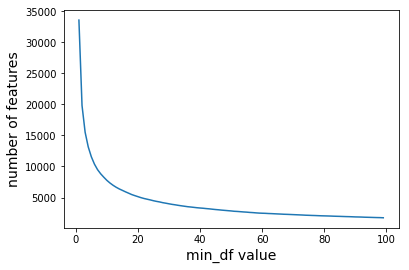

In [10]:
# plot how number of features change with min_df
plt.plot(num_of_features.keys(), num_of_features.values())
plt.xlabel('min_df value', size=14)
plt.ylabel('number of features', size=14)

In [11]:
# test max_df
num_of_features_max_df = defaultdict()
lin = np.arange(2000,3898,100)
for l in lin:
    vectorizer = TfidfVectorizer(ngram_range=(1,1),stop_words='english', token_pattern="\\b[a-z][a-z]+\\b", min_df=5, max_df=l)
    counts = vectorizer.fit_transform(nytimes['lem_text'])
    nyt_feature_names = vectorizer.get_feature_names()
    num_of_features_max_df[l] = len(nyt_feature_names)

Text(0,0.5,'number of features')

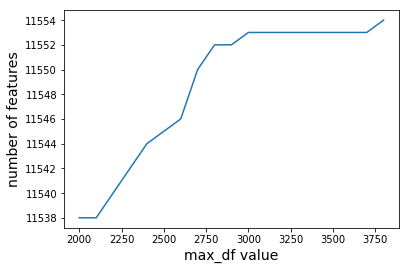

In [12]:
plt.plot(num_of_features_max_df.keys(), num_of_features_max_df.values())
plt.xlabel('max_df value', size=14)
plt.ylabel('number of features', size=14)